In [55]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [57]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [58]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [59]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [60]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [61]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [62]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [63]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 76ms/step - loss: 0.0849 - val_loss: 0.0510
Epoch 2/100
21/21 [==============================] - 2s 84ms/step - loss: 0.0124 - val_loss: 0.0066
Epoch 3/100
21/21 [==============================] - 2s 93ms/step - loss: 0.0032 - val_loss: 9.8297e-04
Epoch 4/100
21/21 [==============================] - 2s 88ms/step - loss: 7.0609e-04 - val_loss: 1.8828e-05
Epoch 5/100
21/21 [==============================] - 1s 58ms/step - loss: 5.0152e-04 - val_loss: 5.5470e-05
Epoch 6/100
21/21 [==============================] - 1s 57ms/step - loss: 4.6094e-04 - val_loss: 6.4139e-05
Epoch 7/100
21/21 [==============================] - 1s 54ms/step - loss: 4.3962e-04 - val_loss: 3.7653e-05
Epoch 8/100
21/21 [==============================] - 1s 56ms/step - loss: 4.2017e-04 - val_loss: 4.8663e-05
Epoch 9/100
21/21 [==============================] - 1s 52ms/step - loss: 4.0595e-04 - val_loss: 4.5092e-05
Epoch 10/100
21/21 [============================

In [65]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 22ms/step


In [66]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [67]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16757.538522977804


In [68]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.08129820972681046], [0.08125407993793488], [0.08097819238901138], [0.08056770265102386], [0.08006764948368073], [0.07950328290462494], [0.07888936251401901], [0.0782354399561882], [0.07754822820425034], [0.07683275640010834], [0.07609288394451141], [0.07533157616853714], [0.07455127686262131], [0.0737539678812027], [0.07294122129678726], [0.07211441546678543], [0.07127471268177032], [0.07042305916547775], [0.06956029683351517], [0.06868711113929749], [0.06780414283275604], [0.06691188365221024], [0.06601082533597946], [0.06510134786367416], [0.0641837790608406], [0.06325843930244446], [0.06232558563351631], [0.061385415494441986], [0.060438141226768494], [0.05948391184210777], [0.058522872626781464], [0.057555146515369415], [0.05658085271716118], [0.05560007691383362], [0.05461287498474121], [0.05361934378743172], [0.05261952057480812], [0.051613446325063705], [0.05060117691755295], [0.04958273842930794], [0.04855813831090927], [0.047527432441711426], [0.04649060592055321], [0.0454

In [69]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16925.88378993],
       [16922.26002818],
       [16899.60524622],
       [16865.89747089],
       [16824.835105  ],
       [16778.491579  ],
       [16728.0788922 ],
       [16674.38138744],
       [16617.95030722],
       [16559.19862455],
       [16498.44325799],
       [16435.92770866],
       [16371.85265085],
       [16306.38082653],
       [16239.64132801],
       [16171.74734047],
       [16102.79430658],
       [16032.85992643],
       [15962.01333478],
       [15890.31081831],
       [15817.80499285],
       [15744.53623798],
       [15670.54493329],
       [15595.86228117],
       [15520.51520136],
       [15444.53000176],
       [15367.92778988],
       [15290.72477874],
       [15212.93840498],
       [15134.58090483],
       [15055.66420862],
       [14976.19841126],
       [14896.19330172],
       [14815.65591586],
       [14734.59084225],
       [14653.00603445],
       [14570.90455152],
       [14488.28975843],
       [14405.16624376],
       [14321.53614886],


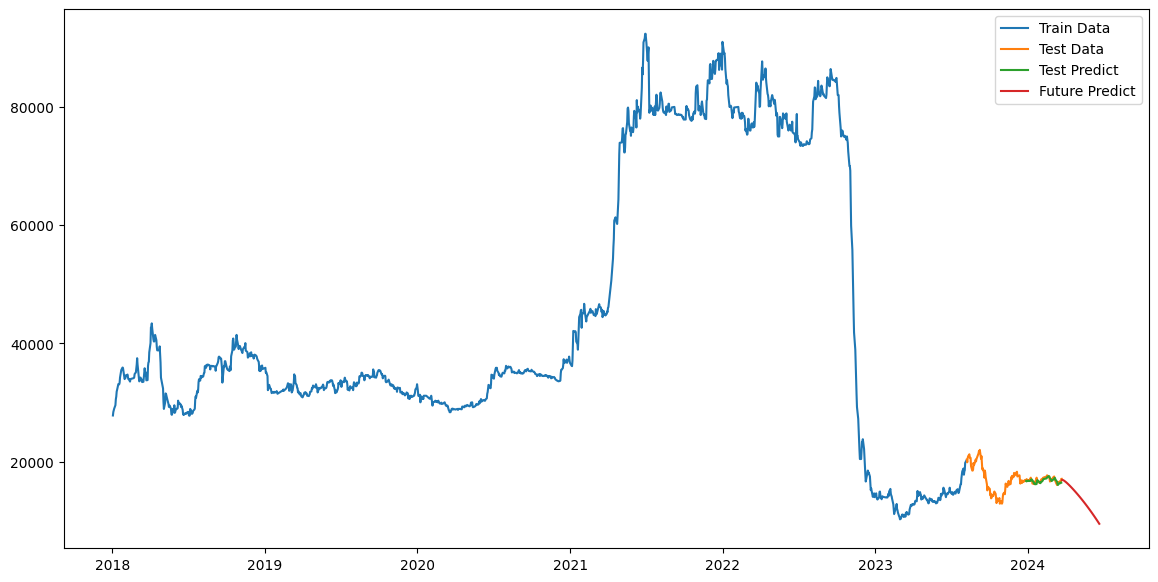

In [75]:
# Calculate future prediction dates
last_test_date = df['Date'].iloc[train_size + test_size - 1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=90)

# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data
plt.plot(df['Date'][train_size + time_step:train_size + test_size-1], y_pred, label='Test Predict')

# Plot future predictions
plt.plot(future_predict_dates, future_predict, label='Future Predict')


# Display the legend
plt.legend()

# Display the plot
plt.show()